In [1]:
# Import necessary Libraraies
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
# The data has been taken from Kaggle per below link
# https://www.kaggle.com/zhangluyuan/ab-testing
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# To checl the Total records
df.shape
#df.describe()

(294478, 5)

## Let's visualize to see of the Data is in sysnc with our target objective and is ready for Tests
* The control group represents the users of Old Page
* The treatment group represents the users of new Page

In [13]:
# The control group represents the users of Old Page
# The treatment group represents the users of new Page
# Lets see hpw the data looke like
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

## Data Anomalies 
* We have noticed above that some users in ‘control group’ have visited  ‘new page’ 
* We have also noticed above that some users in ‘treatment group’ have visited ‘old page’
* Now instead of cleaning the data we can only pick the relevant data (control/new_page and treatment/old_page) with the help of below code .

In [9]:
# from 'Control Group' we only need old page
# From 'Treatment Group' we only need new page
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') 
                    & (df['landing_page'] == 'new_page')]
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [11]:
# Checking for duplicate values
print(df_cleaned['user_id'].duplicated().sum())
# Finding user_id for duplicate value
df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]['user_id']

1


1899    773192
2893    773192
Name: user_id, dtype: int64

In [8]:
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Now we need to drop the Duplicates
df_cleaned = df.drop_duplicates(subset='user_id',keep="first")

In [15]:
user_groups= df_cleaned.groupby(['group','landing_page','converted']).size()
#user_groups

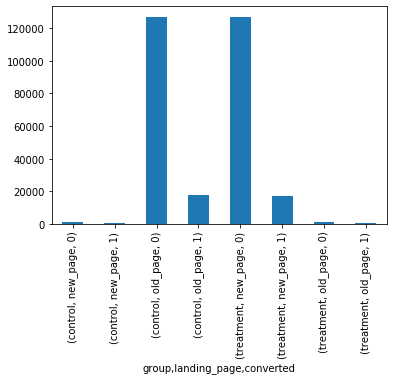

In [16]:
user_groups.plot.bar()

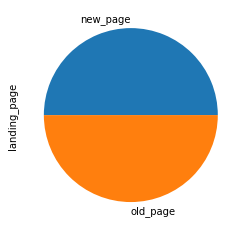

In [13]:
# To check the proportion of users in each group to see if the classes are balanced
df_cleaned['landing_page'].value_counts().plot.pie()

In [21]:
### To prepare and arrange the Data for Chi-Square Contigency Table 
# 1) Take out the Control group 
control = df_cleaned[df_cleaned['group'] == 'control']
# 2) Take out the Treatment group 
treatment = df_cleaned[df_cleaned['group'] == 'treatment']
# 2A) A-click - i.e The ones who converted from Control group
control_click = control.converted.sum()
# 2B) No-click,i.e The one who did not click from Control group
control_noclick = control.converted.size - control.converted.sum()
#3 B-click, B-noclick
# 3A) A-click - i.e The ones who converted from Treatment group
treatment_click = treatment.converted.sum()
# 2B) No-click,i.e The one who did not click from Treatment group
treatment_noclick = treatment.converted.size - treatment.converted.sum()
# 3) Create np array
Table = np.array([[control_click, control_noclick], [treatment_click, treatment_noclick]])

[[ 17471 127761]
 [ 17274 128078]]


# We would like to find compare the old group vs new group
# Null Hypothesis:
* The new landing page and old landing page is same for users

# Alternative Hypothesis: 
* The Old and New landing page is different for the users

In [24]:
import scipy
from scipy import stats
# The correction will Adjust the observerd value by .5 towards the corressponding Expected Values
stat,p,dof,expected = scipy.stats.chi2_contingency(Table,correction=True)
print('\nStat : ',stat)
print('\nP-Value : ',p)
print('\nDegree of Freedom : ',dof)
print('\nObserved Frequencies: ',Table)
print('\nExpected Frequencies: ',expected)


Stat :  1.446408325649827

P-Value :  0.2291051425206025

Degree of Freedom :  1

Observed Frequencies:  [[ 17471 127761]
 [ 17274 128078]]

Expected Frequencies:  [[ 17365.32582661 127866.67417339]
 [ 17379.67417339 127972.32582661]]


# Decision Rule If P-calculated value < level of significance then Reject H0
# When Tests Stats > Critical Value then reject H0

In [29]:
# The test tatistic
prob = 0.95
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Independent (fail to reject H0)


In [30]:
# interpret p-value
alpha = 1.0 - prob
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

Independent (fail to reject H0)


In [13]:
print(scipy.stats.chi2_contingency(T,correction=True)[1])

0.19158976298516012


# The P-Vlaue is 19% , At 5% level of significance the P-vlaue is greater than  Alpha so we do not Reject the Null Hypothesis
# The old and new page's users have same click and conversion rate

# The conversion rate is considered independent as the observed and expected frequencies are similar, the variables do not interact and are not dependent.

In [34]:
# Cross Check
print('\nThe difference of Observed vs Expected Frequencies\n',expected-Table)


The difference of Observed vs Expected Frequencies
 [[-114.7125385  114.7125385]
 [ 114.7125385 -114.7125385]]


In [36]:
# Cross Check
control_group = control_click/ (control_click + control_noclick)
treatment_group = treatment_click / (treatment_click + treatment_noclick)
print(control_group, treatment_group )

0.1203863045004612 0.11880724790277405


# The conversion rate of 11% to 12% is not much different so both groups are not different 